In [1]:
import pandas as pd
import requests
import json

#Url das competições disponíveis
url = "http://api.football-data.org/v4/competitions"

#Token de acesso à API
token = "8eb5bfa2879d4e009bc7eca39615bf5c"

headers = {
    'X-Auth-Token': token
}

#Pedido get para aceder às competições e conversão para json
competicoes = requests.get(url, headers=headers).json()

#Filtro
lista_competicoes=competicoes.get('competitions')

#Loop para verificar competições disponíveis
for competicao in lista_competicoes:
    print(competicao.get('name'))

#Loop para aceder aos dados da Primeira Liga
for liga in lista_competicoes:
    if liga.get('name')=='Primeira Liga':
        liga_portuguesa = liga
liga_portuguesa

Campeonato Brasileiro Série A
Championship
Premier League
UEFA Champions League
European Championship
Ligue 1
Bundesliga
Serie A
Eredivisie
Primeira Liga
Copa Libertadores
Primera Division
FIFA World Cup


{'id': 2017,
 'area': {'id': 2187,
  'name': 'Portugal',
  'code': 'POR',
  'flag': 'https://crests.football-data.org/765.svg'},
 'name': 'Primeira Liga',
 'code': 'PPL',
 'type': 'LEAGUE',
 'emblem': 'https://crests.football-data.org/PPL.png',
 'plan': 'TIER_ONE',
 'currentSeason': {'id': 2312,
  'startDate': '2024-08-11',
  'endDate': '2025-05-17',
  'currentMatchday': 23,
  'winner': None},
 'numberOfAvailableSeasons': 76,
 'lastUpdated': '2024-09-13T16:54:08Z'}

In [2]:
#Url para jogos da Primeira Liga
url_liga_portuguesa = "http://api.football-data.org/v4/competitions/2017/matches"

#Pedido get para aceder aos jogos da Primeira Liga e conversão para json
jogos_liga_portuguesa = requests.get(url_liga_portuguesa, headers=headers).json()


In [3]:
#Filtro
jogos = jogos_liga_portuguesa.get('matches')

#criar array para armazenar nome das equipas
lista_equipas = []

#Loop para obter nome de todas as equipas
for jogo in jogos:
    if jogo.get('homeTeam').get('name') not in lista_equipas:
        lista_equipas.append(jogo.get('homeTeam').get('name'))

#print(lista_equipas)

#Criar DataFrame com as colunas necessárias
tabela = pd.DataFrame({
    'Posição': 0,
    'Equipa': lista_equipas,
    'Jogos': 0,
    'Vitórias': 0,
    'Empates': 0,
    'Derrotas': 0,
    'Golos Marcados': 0,
    'Golos Sofridos': 0,
    'Diferença de Golos': 0,
    'Pontos': 0,
    'Jogos a Ganhar ao Intervalo em Casa': 0,
    'Jogos Segurados em Casa': 0,
    '% Jogos Segurados em Casa': 0.0,
    'Jogos a Perder ao Intervalo': 0,
    'Reviravoltas na 2ª Parte': 0,
    '% Reviravoltas na 2ª Parte': 0.0
})

#print(tabela)

#Iterar sobre cada jogo da lista de jogos
for jogo in jogos:

    #Verificação de que o jogo está terminado para aceder às estatísticas (Há Jogos que foram interrompidos)
    if jogo.get('status') == 'FINISHED':

        #Filtrar Dados Relevantes do Jogo
        visitado = jogo.get('homeTeam').get('name')
        visitante = jogo.get('awayTeam').get('name')
        vencedor = jogo.get('score').get('winner')
        golos_visitado = jogo.get('score').get('fullTime').get('home')
        golos_visitado_intervalo = jogo.get('score').get('halfTime').get('home')
        golos_visitante = jogo.get('score').get('fullTime').get('away')
        golos_visitante_intervalo = jogo.get('score').get('halfTime').get('away')
       

        #Atualizar Nº Jogos
        tabela.loc[tabela['Equipa'] == visitado, 'Jogos'] += 1
        tabela.loc[tabela['Equipa'] == visitante, 'Jogos'] += 1

        #Atualizar Golos Marcados e Sofridos
        tabela.loc[tabela['Equipa'] == visitado, 'Golos Marcados'] += golos_visitado
        tabela.loc[tabela['Equipa'] == visitado, 'Golos Sofridos'] += golos_visitante

        tabela.loc[tabela['Equipa'] == visitante, 'Golos Marcados'] += golos_visitante
        tabela.loc[tabela['Equipa'] == visitante, 'Golos Sofridos'] += golos_visitado

        #Atualizar Nº Vitórias/Empates/Derrotas
        if vencedor == 'DRAW':
            tabela.loc[tabela['Equipa'] == visitado , 'Empates'] += 1
            tabela.loc[tabela['Equipa'] == visitante, 'Empates'] += 1

        elif vencedor == 'HOME_TEAM':
            tabela.loc[tabela['Equipa'] == visitado, 'Vitórias'] += 1
            tabela.loc[tabela['Equipa'] == visitante, 'Derrotas'] += 1

        else:
            tabela.loc[tabela['Equipa'] == visitado, 'Derrotas'] += 1
            tabela.loc[tabela['Equipa'] == visitante, 'Vitórias'] += 1
    
        #Cálculo de Jogos Segurados em Casa
        if (golos_visitado_intervalo > golos_visitante_intervalo):
            tabela.loc[tabela['Equipa'] == visitado, 'Jogos a Ganhar ao Intervalo em Casa'] += 1
            if (vencedor == 'HOME_TEAM'):
                tabela.loc[tabela['Equipa'] == visitado, 'Jogos Segurados em Casa'] += 1

        #Cálculo de Reviravoltas após estar a perder ao intervalo
        if (golos_visitado_intervalo > golos_visitante_intervalo):
            tabela.loc[tabela['Equipa'] == visitante, 'Jogos a Perder ao Intervalo'] += 1
            if (golos_visitado < golos_visitante):
                tabela.loc[tabela['Equipa'] == visitante, 'Reviravoltas na 2ª Parte'] += 1
        elif (golos_visitado_intervalo < golos_visitante_intervalo):
            tabela.loc[tabela['Equipa'] == visitado, 'Jogos a Perder ao Intervalo'] += 1
            if (golos_visitado > golos_visitante):
                tabela.loc[tabela['Equipa'] == visitado, 'Reviravoltas na 2ª Parte'] += 1


#Cálculo das restantes colunas
tabela['Diferença de Golos'] = tabela['Golos Marcados'] - tabela['Golos Sofridos']
tabela['Pontos'] = tabela['Vitórias']*3 + tabela['Empates'] * 1

#Ordenar a Tabela Classificativa
tabela = tabela.sort_values(["Pontos","Diferença de Golos"], ascending = [False, False])
tabela['Posição'] = range(1, 19)
tabela['% Jogos Segurados em Casa'] = (tabela['Jogos Segurados em Casa'] / tabela['Jogos a Ganhar ao Intervalo em Casa'] * 100).round(2)
tabela['% Reviravoltas na 2ª Parte'] = (tabela['Reviravoltas na 2ª Parte'] / tabela['Jogos a Perder ao Intervalo'] * 100).round(2)
    

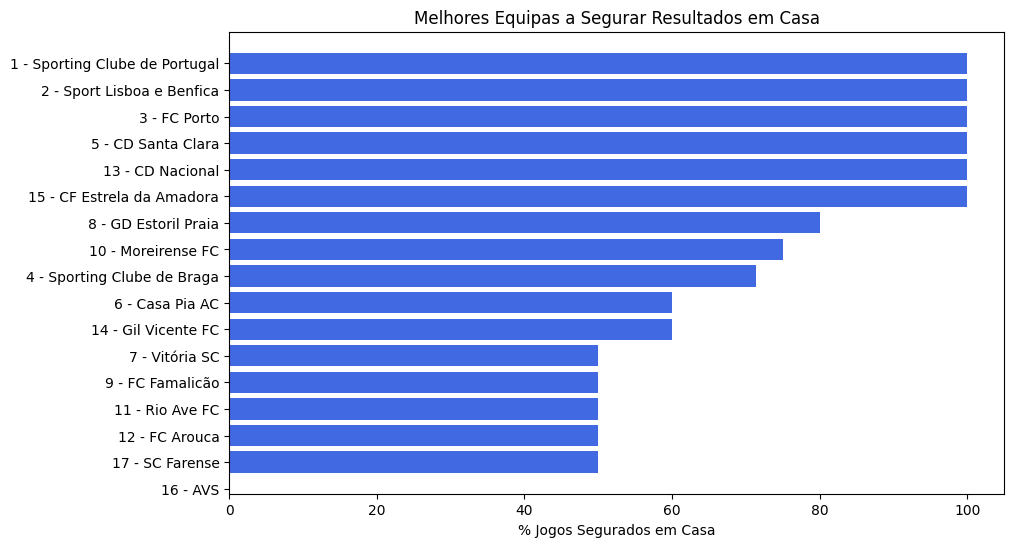

In [26]:
import matplotlib.pyplot as plt

# Ordenar a tabela por % Jogos Segurados em Casa (decrescente)
tabela_ordenada = tabela.sort_values(by='% Jogos Segurados em Casa', ascending=False)

# Criar uma nova coluna com posição + nome da equipa
tabela_ordenada['Equipa_Label'] = tabela_ordenada['Posição'].astype(str) + " - " + tabela_ordenada['Equipa']

# Criar gráfico de barras horizontais
plt.figure(figsize=(10, 6))
plt.barh(tabela_ordenada['Equipa_Label'], tabela_ordenada['% Jogos Segurados em Casa'], color='royalblue')

plt.xlabel('% Jogos Segurados em Casa')
plt.title('Melhores Equipas a Segurar Resultados em Casa')

plt.gca().invert_yaxis()  # Para manter a melhor equipa no topo
plt.show()


## Análise da Relação entre a Posição no Campeonato e a Capacidade de Segurar Resultados em Casa  

Existe uma correlação geral entre a posição das equipas no campeonato e a sua capacidade de segurar resultados em casa, mas não é uma relação absoluta.  

As equipas que lideram a tabela, como **Sporting CP, Benfica, FC Porto e Santa Clara**, apresentam uma elevada percentagem de jogos segurados, o que sugere que as equipas mais bem classificadas são mais consistentes a manter a vantagem quando estão a vencer ao intervalo.  

No entanto, há algumas exceções, como **CD Nacional e CF Estrela da Amadora**, que, apesar de terem uma elevada percentagem de jogos segurados, não ocupam as posições cimeiras na classificação. Isto pode indicar que conseguem manter vantagens quando lideram, mas talvez tenham menos jogos em que efetivamente estiveram na frente do marcador.  

Uma surpresa negativa nesta métrica são o **Sporting de Braga, Casa Pia e Vitória SC**, que, apesar de estarem relativamente bem classificados no campeonato, apresentam valores bastante abaixo do esperado na capacidade de segurar resultados em casa. Este desempenho aquém da média pode indicar que estas equipas enfrentam dificuldades em controlar os jogos após assumirem a vantagem, algo que contrasta com o seu posicionamento na tabela geral.  

Por outro lado, as equipas nas últimas posições, como **AVS e SC Farense**, estão entre as que apresentam uma menor percentagem de jogos segurados, o que pode refletir dificuldades em manter resultados positivos em casa.  

Assim, embora exista uma tendência para que as melhores equipas sejam também as mais eficazes a segurar resultados, este fator não é o único determinante do seu sucesso na classificação.

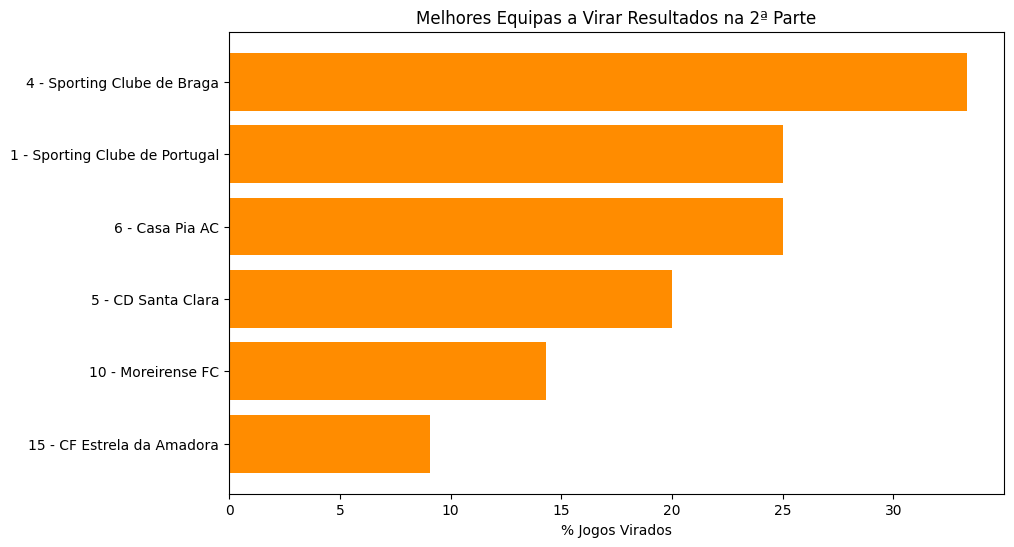

In [27]:
import matplotlib.pyplot as plt

# Filtrar apenas as equipas que têm % Reviravoltas > 0
tabela_filtrada = tabela[tabela['% Reviravoltas na 2ª Parte'] > 0]

# Ordenar a tabela por % de reviravoltas (decrescente)
tabela_ordenada = tabela_filtrada.sort_values(by='% Reviravoltas na 2ª Parte', ascending=False)

# Criar uma nova coluna com posição + nome da equipa
tabela_ordenada['Equipa_Label'] = tabela_ordenada['Posição'].astype(str) + " - " + tabela_ordenada['Equipa']

# Criar gráfico de barras horizontais
plt.figure(figsize=(10, 6))
plt.barh(tabela_ordenada['Equipa_Label'], tabela_ordenada['% Reviravoltas na 2ª Parte'], color='darkorange')

plt.xlabel('% Jogos Virados')
plt.title('Melhores Equipas a Virar Resultados na 2ª Parte')

# Inverter eixo Y para mostrar a melhor equipa no topo
plt.gca().invert_yaxis()

plt.show()


## Análise das Equipas que Conseguiram Virar Resultados na 2ª Parte Após Estarem a Perder ao Intervalo

Poucas equipas foram capazes, até agora no campeonato, de recuperar de uma desvantagem ao intervalo e sair com a vitória no final do jogo. Isto indica que, em geral, quando uma equipa está a perder ao intervalo, tem dificuldades em inverter o resultado, o que demonstra a importância da vantagem inicial no futebol.  

No entanto, algumas equipas destacam-se nesta métrica, com o **Sporting de Braga** a ser a equipa mais eficaz a virar jogos, conseguindo recuperar a desvantagem na 2ª parte em cerca de 33% das ocasiões. **Sporting CP e Casa Pia AC** também apresentam um desempenho notável nesta estatística, demonstrando uma forte capacidade de reação após um mau início de jogo.  

Outras equipas, como **CD Santa Clara, Moreirense FC e CF Estrela da Amadora**, também conseguiram reviravoltas, mas em menor frequência. O **CF Estrela da Amadora**, apesar de estar numa posição mais baixa na tabela, aparece entre as equipas que já conseguiram virar resultados, o que pode indicar um espírito de luta da equipa, mesmo que os resultados globais não sejam tão positivos.  

Por outro lado, a maioria das equipas do campeonato não aparece nesta lista, o que reforça que inverter um resultado ao intervalo é um feito difícil e relativamente raro. As equipas que conseguem fazê-lo mostram não só uma mentalidade forte, mas também a capacidade de ajustar a estratégia e reagir melhor às adversidades ao longo do jogo.


In [ ]:
#Tabela Final
tabela

,Posição,Equipa,Jogos,Vitórias,Empates,Derrotas,Golos Marcados,Golos Sofridos,Diferença de Golos,Pontos,Jogos a Ganhar ao Intervalo em Casa,Jogos Segurados em Casa,% Jogos Segurados em Casa,Jogos a Perder ao Intervalo,Reviravoltas na 2ª Parte,% Reviravoltas na 2ª Parte
0,1,Sporting Clube de Portugal,22,16,4,2,59,18,41,52,7,7,100.00,4,1,25.00
13,2,Sport Lisboa e Benfica,22,16,2,4,50,18,32,50,8,8,100.00,3,0,0.00
3,3,FC Porto,22,14,4,4,46,18,28,46,6,6,100.00,6,0,0.00
7,4,Sporting Clube de Braga,22,13,5,4,38,20,18,44,7,5,71.43,3,1,33.33
9,5,CD Santa Clara,22,12,2,8,25,23,2,38,3,3,100.00,5,1,20.00
2,6,Casa Pia AC,22,9,6,7,29,28,1,33,5,3,60.00,4,1,25.00
15,7,Vitória SC,22,7,10,5,30,25,5,31,4,2,50.00,5,0,0.00
4,8,GD Estoril Praia,22,8,7,7,28,34,-6,31,5,4,80.00,6,0,0.00
6,9,FC Famalicão,22,6,10,6,24,24,0,28,4,2,50.00,4,0,0.00
14,10,Moreirense FC,22,7,5,10,28,33,-5,26,4,3,75.00,7,1,14.29
